In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import warnings
import logging
import os
import time
import math

import scipy
from scipy import optimize
from scipy.optimize import basinhopping
from scipy.stats import gengamma,t
from math import *
from numpy import *
from numpy.linalg import norm 
import numpy.linalg as a 

import statistics 


def basinQ(x):
    if norm(optimal-x)<=1e-5:
        return 1
    else:
        return 0
    
def monotonicityconstraintQ(x, function, threshold):
    # checks threshold value constraints
    return function(x),function(x) < threshold

def boundaryconstraintQ(x, boxsize):
    # checks only boundary constraints
    return bool(np.all(x <= boxsize)) and bool(np.all(x >= -boxsize))

def bothconstraintsQ(x, boxsize, function, threshold):
    # checks for both boundary and threshold value constraints
    return boundaryconstraintQ(x, boxsize) and monotonicityconstraintQ(x, function, threshold)

def bothconstraintsQindependent(x, boxsize, function, threshold):
    # checks for both boundary and threshold value constraints independently
    return boundaryconstraintQ(x, boxsize), monotonicityconstraintQ(x, function, threshold)

def checkcoordinates(x):
   # print('x',x)
    x = x[0]
    #print('x',x)
    newx = x
    
    for i in range(x.shape[0]):
        if x[i]>maxx[i]:
            newx[i] = x[i] -interval[i]
        elif x[i]<minn[i]:
            newx[i] = x[i] + interval[i]
   # print('xnew',newx)
    return newx


def check_smc_coordinates(x, boxsize):
    newx = x
    locate = abs(x)>boxsize
    sign = np.sign(x)
    newx[locate]= x[locate]-sign[locate]*2*boxsize
    return newx


# In[2]:


class ClassicalTakeStep(object):
    
    def __init__(self, boxsize, periodicboundary=False, proposeoutsidebounds=False):
        #self.stepsize = stepsize
        self.boxsize = boxsize
        self.periodicboundary = periodicboundary
        self.proposeoutsidebounds = proposeoutsidebounds
        
        
    def __call__(self, x):
        #start_pert = time.time()
        sigma = aa #self.stepsize
        boxsize = self.boxsize
        periodicboundary = self.periodicboundary
        proposeoutsidebounds = self.proposeoutsidebounds

        global iterations, pert_duration, skips
        
        distance = 0                
        iterations +=1
        d = x.shape[0]
        skips = 1
        phi = np.random.normal(loc=0.0, scale=sigma, size=d)
        phi = phi/np.linalg.norm(phi)
        beta = math.sqrt(2*sigma)
        r = gengamma.rvs(a = d/2., c = 2., loc = 0., scale = beta, size = 1)
        xnew = x + phi*r[0]
        
        if proposeoutsidebounds or boundaryconstraintQ(xnew, boxsize):
            yy= xnew
        elif periodicboundary:
            xnew = checkcoordinates(array([xnew]))
            yy= xnew
        else:
            yy= x
            
        outside(x,yy,r,1)
       # pert_duration += time.time() - start_pert
        return yy
    
class callbackiguess(object):
    #This will stop the basin hopping routine when the returned test is true
    def __init__(self):
        self.time_taken = 0

    def __call__(self,x,f,accept):
        self.time_taken = (time.time() - start)>limit
        return self.time_taken
    
    
class MonotonicSkippingSMCTakeStep(object):
    
    def __init__(self, function, boxsize, maxjumps, NParticles,periodicboundary,proposeoutsidebounds):#,NParticles):
        self.function = function
        self.maxjumps = maxjumps
        self.NParticles = NParticles
        self.boxsize = boxsize
        self.periodicboundary = periodicboundary
        self.proposeoutsidebounds = proposeoutsidebounds
        
    def __call__(self, x):
        global iterations,nfval,skips#,pert_duration

       # ab = time.time()
        d= x.shape[0]
        sigma = (aa**2)*np.identity(d)
        maxjumps = self.maxjumps
        boxsize = self.boxsize
        periodicboundary = self.periodicboundary
        proposeoutsidebounds = self.proposeoutsidebounds
        function = self.function
        NParticles = self.NParticles
        
        distance = zeros([NParticles])
        displacement = 0
        iterations+=1
  
        fval = function(array(x))
        nfval+=1
        
        phi = np.random.multivariate_normal(mean=np.zeros(d), cov=sigma, size=NParticles)
        phi = phi/np.linalg.norm(phi)
        chisqr = np.random.chisquare(d,size=NParticles)
        r=np.sum((phi@np.linalg.inv(sigma))*phi,1)**(-0.5)*np.sqrt(chisqr)
        distance += r
        move =(r*phi.T).T
        new_xs = x + move
        particle_steps = np.ones(NParticles)
        
        
        if proposeoutsidebounds:
            new_xs = check_smc_coordinates(new_xs, boxsize)
            func_results,monotonicityflag = monotonicityconstraintQ(new_xs, function, fval)
            nfval += len(new_xs)
            active_particle_index = [True]
            
            while any(active_particle_index): 
                
                active_particle_index = (particle_steps.T<maxjumps)*(~monotonicityflag)
                r=np.sum((phi[active_particle_index,:]@np.linalg.inv(sigma))*
                         phi[active_particle_index,:],1)**(-0.5)*np.sqrt(chisqr[active_particle_index])
                move =(r*phi[active_particle_index,:].T).T
                new_xs[active_particle_index] += move
                distance[active_particle_index] += r
                particle_steps[active_particle_index] +=1
                func_results[active_particle_index],monotonicityflag[active_particle_index] = monotonicityconstraintQ(new_xs[active_particle_index], function, fval)
                nfval += len(new_xs[active_particle_index])
                
            if any(monotonicityflag):
               
                xnew = new_xs[func_results==min(func_results[monotonicityflag]),:]
                yy = xnew 
                ll=func_results[monotonicityflag]
                winning_chain = where(func_results==min(ll))
                skips = particle_steps[winning_chain]
                displacement = distance[winning_chain]

            else:
                yy = x
 
        elif periodicboundary:
            new_xs = check_smc_coordinates(new_xs, boxsize)
            func_results,monotonicityflag = monotonicityconstraintQ(new_xs, function, fval)
            nfval += len(new_xs)
            active_particle_index = [True]
            
            while any(active_particle_index): 
                active_particle_index = (particle_steps.T<maxjumps)*(~monotonicityflag)
                r=np.sum((phi[active_particle_index,:]@np.linalg.inv(sigma))*
                         phi[active_particle_index,:],1)**(-0.5)*np.sqrt(chisqr[active_particle_index])
                move =(r*phi[active_particle_index,:].T).T
                distance[active_particle_index]+=r
                new_xs[active_particle_index] += move
                new_xs[active_particle_index] = check_smc_coordinates(new_xs[active_particle_index], boxsize)
                particle_steps[active_particle_index] +=1
                func_results[active_particle_index],monotonicityflag[active_particle_index] = monotonicityconstraintQ(new_xs[active_particle_index], function, fval)

                nfval += len(func_results[active_particle_index])
 
            if any(monotonicityflag): #THESE ARE SUCCESSFUL JUMPS, BOTH SKIPS AND RANDOM WALKS
                
                ll=func_results[monotonicityflag]
                xnew =  new_xs[func_results==min(ll),:]
                winning_chain = where(func_results==min(ll))
                yy = xnew
                skips = particle_steps[winning_chain]
                displacement = distance[winning_chain]
            else:
                yy= x  
        outside(x,yy,displacement,particle_steps)
        #pert_duration += time.time() - ab
        return yy
     
class MyBounds(object):
    
    def __init__(self):
        self.xmax = np.array(maxx)
        self.xmin = np.array(minn)
        
    def __call__(self, **kwargs):
        global accept_duration
        ab = time.time()
        x = kwargs["x_new"]
        #print(T)
        z = bool(np.all(x <= self.xmax)) and bool(np.all(x >= self.xmin))
       # print(z)
        accept_duration+=time.time()-ab
        return z
    
def outside(x,y,r,all_skips):
    global key,avg_all_skips,YY,XX
    key = r
    YY = y
    XX=x
    avg_all_skips.append(mean(all_skips))
    
    
class MJSD(object):
    
    def __init__(self):
        self.a = 1
        
    def __call__(self,x,f,accept):
        
        global key,rw_dist,skips,skip_dist,moves,list_succ_skips,proposals,mjsd_duration,improved_move,total_displacement,bad_move
        ab = time.time()
        #print('ab',ab)
        proposals +=1
        #THIS CALCULATES THE NUMBER OF RW MOVES AND NUMBER OF SKIPPING (K>1 AND ACCEPT) MOVES
        
        
        if accept==True and FUNCTION(x)<=FUNCTION(XX) and key>0:
            improved_move+=1
        if accept==True and FUNCTION(x)>FUNCTION(XX) and key>0:
            bad_move+=1
        #if accept==True:
            

        if accept==True and key>0:
            moves+=1
            total_displacement+=key
            
            if skips==1:
                rw_dist=append(rw_dist,key)
            elif skips>1:
                skip_dist = append(skip_dist,key)
                list_succ_skips.append(skips)
                #print(list_succ_skips)

        mjsd_duration+= time.time() - ab
        #print('mjsd time',mjsd_duration)

In [2]:
def whitley(x):
 
    if len(x.shape) ==1:
        return sum([sum([((100*(x[i]**2-x[j])**2 + (1-x[i])**2)**2 )/4000 -
          cos(100*(x[i]**2 - x[j])**2+(1-x[j])**2)+1 for j in range(2)])for i in range(2)])
    else:
        return sum([sum([((100*(x[:,i]**2-x[:,j])**2 + (1-x[:,i])**2)**2 )/4000 -
          cos(100*(x[:,i]**2 - x[:,j])**2+(1-x[:,j])**2)+1 for j in range(2)],axis=0)for i in range(2)],axis=0)



FUNCTION = whitley
boxsize = 10.24
minn = 10.24*array([-1,-1])
maxx = 10.24*array([1,1])
interval = maxx - minn
seed = math.floor(time.time())
key = 0
moves = 0
rw_dist = []
skip_dist = []
list_succ_skips=[]
avg_all_skips = []
fail_rw=[];fail_skip=[]
chosen_distance = 0
mjsd = MJSD()
dimension_list = np.array([2])
x_initial = np.random.uniform(low=minn, high=maxx, size=[20000,dimension_list[-1]])

jump_list = np.array([25])#25,10,5,2])
variance = np.array([0.4])  #2*boxsize/jump_list
niter = 100000
len_dim = len(dimension_list)
len_var = len(variance)
method ="L-BFGS-B"

limit_evals = 10000000 #maximum number of function evaluations
limit_time = 10
limit_iterations = 100000
same_place_iter = 50

classicmytakestep = ClassicalTakeStep(boxsize=boxsize, periodicboundary=False,proposeoutsidebounds=True)


# In[8]:


#CONFIDENCE INTERVAL FUNCTIONS

def conf_int_PIB(pib,i):
    uCI = pib+1.96*np.sqrt(pib*(1-pib/100)/i)
    lCI = pib-1.96*np.sqrt(pib*(1-pib/100)/i)
    return ([lCI,uCI])

def t_con_int(mu,input_list,n):
    t_value = t.ppf(0.5+0.95/2, df=n-1, loc=0, scale=1)
    sam_sig = sample_error(n,input_list)
    CI = [mu-t_value*sam_sig/sqrt(n),mu+t_value*sam_sig/sqrt(n)]
    return CI

def sample_error(N_succ,input_list):
    return np.sqrt(np.sum((input_list-np.mean(input_list))**2)/(N_succ-1))



In [3]:
class AlternatingPertubation(object):

    def __init__(self,classic,skip):
        
        self.classic=classic
        self.skip = skip
        
    def __call__(self,x):
        ab = time.time()
        classic = self.classic
        skip = self.skip
        
        global switch,pert_duration,T
        #print(switch_interval,switch)
        
        if ((switch_interval>0 and mod(switch,switch_interval)>0) or (switch_interval<0 and mod(switch,switch_interval)==0)):
   
            t = skip(x)
        #    print('skip \t')
           # print('switch interval',switch_interval)
        else:

            t = classic(x)
           # print('classic \t')
        
        switch+=1
        pert_duration+=time.time()-ab
        return t
    


In [22]:
#ALTERNATING SKIPPING SAMPLER WITH N PARTICLES
#global dist, rw_dist, skip_dist, skips_succ_chai

NParticle_list = array([1])
switches = array([1,-20,-10,-5,2,5,10,20,-1])
#periodic boundaries
tt= True
ff = False

len_part = len(switches)
len_jump=len_var

exp_EMJD_rw_s   = np.ones([len_dim,len_part,len_jump])
exp_EMJD_skip_s = np.ones([len_dim,len_part,len_jump])

total_trials_s=  np.ones([len_dim,len_part,len_jump])
total_in_basin_s=np.ones([len_dim,len_part,len_jump])
total_evaluations_s=np.ones([len_dim,len_part,len_jump])
total_iterations_s= np.ones([len_dim,len_part,len_jump])
total_time_s= np.ones([len_dim,len_part,len_jump])
perturbation_time_s = np.ones([len_dim,len_part,len_jump])
local_min_time_s = np.ones([len_dim,len_part,len_jump])
PSS_s =np.ones([len_dim,len_part,len_jump])
PSrw_s = np.ones([len_dim,len_part,len_jump])
accept_rate_s = np.ones([len_dim,len_part,len_jump])
mean_all_skips= np.ones([len_dim,len_part,len_jump])
mean_succ_skips = np.ones([len_dim,len_part,len_jump])
PIB_s=np.ones([len_dim,len_part,len_jump])
EpS_s=np.ones([len_dim,len_part,len_jump])
IpS_s=np.ones([len_dim,len_part,len_jump])
TpS_s=np.ones([len_dim,len_part,len_jump])
avg_iteration = np.ones([len_dim,len_part,len_jump])
CI_PIB_s=np.ones([len_dim,len_part,len_jump,2])
CI_EpS_s=np.ones([len_dim,len_part,len_jump,2])
CI_IpS_s=np.ones([len_dim,len_part,len_jump,2])
CI_TpS_s=np.ones([len_dim,len_part,len_jump,2])

total_perturbation_evals=np.ones([len_dim,len_part,len_jump])
total_localopt_evals=np.ones([len_dim,len_part,len_jump])
avg_perturbation_evals=np.ones([len_dim,len_part,len_jump])
avg_localopt_evals=np.ones([len_dim,len_part,len_jump])
avg_all_evals=np.ones([len_dim,len_part,len_jump])
ratio_evals=np.ones([len_dim,len_part,len_jump])

NUM_improved_final_move=np.ones([len_dim,len_part,len_jump])
NUM_bad_final_move = np.ones([len_dim,len_part,len_jump])

percent_improved_final_move=np.ones([len_dim,len_part,len_jump])
percent_bad_final_move = np.ones([len_dim,len_part,len_jump])

total_displacements = np.ones([len_dim,len_part,len_jump])
Moves = np.ones([len_dim,len_part,len_jump])
T = 1

for z in range(len_dim):

    dimension = dimension_list[z]
    x0 = x_initial[:,0:dimension]

    xmin = minn
    xmax = maxx
    
    bounds = [(low, high) for low, high in zip(xmin, xmax)] #bounds for local minimizer (rewritten in the way required by L-BFGS-B, which can be used as the problem is smooth and bounded)
    minimizer_kwargs = dict(bounds=bounds, method=method,tol=1e-6)
    mybounds = MyBounds() #bounds for accept_test
    optimal = array([0.9997112 , 0.99971121])#*np.ones(dimension)
    
    for y in range(len_part):
        
        #NPart = NParticle_list[y]
        #print(NPart)
        switch_interval = switches[y]
        
        for xx in range(len_var):

            #initializations
      
            ft_cinimum_pos_s = []
            ft_cinimum_vals_s = []
            ft_cinimums_dist_s = []
            ft_function_evals_s = []
            ft_basin_iterations_s = []
            ft_end_time_s = []
            ft_in_basin_s = []
            final_time_s=0
            trial_cJD_rw =[]
            trial_cJD_skip = []
            list_succ_skips=[]
            avg_all_skips = []
            
            perturbation_evals =[]
            localopt_evals =[]
            i= 0
            total_evaluations = 0
            iterations = 0
            start = time.time()
            
            max_jump=jump_list[xx]
            aa = variance[xx]
            switch = 1
            

            if switch_interval==1:
                classic = ClassicalTakeStep(boxsize=boxsize, periodicboundary=tt, 
                                          proposeoutsidebounds=ff)
            else:
                classic = ClassicalTakeStep(boxsize=boxsize, periodicboundary=tt, 
                                          proposeoutsidebounds=ff)

            skipping = MonotonicSkippingSMCTakeStep(function=FUNCTION, maxjumps=max_jump,
                                                                   boxsize=boxsize,NParticles=1, 
                                                                   periodicboundary=tt, proposeoutsidebounds=ff)
            
            alternating = AlternatingPertubation(classic=classic,skip=skipping)
            
            duration = 0
            evaluations = 0
            skips = 0               
            moves = 0
            rw_dist = []
            skip_dist = [] 
            proposals = 0
            accept_duration = 0
            mjsd_duration = 0
            pert_duration = 0
            improved_move=0
            total_displacement=0
            bad_move=0
            #THIS WHILE LOOP INITIATES THE EXPERIMENT

            while duration<=limit_time:
                
                nfval = 0
                each_start = time.time()
                XX=x0[i]
                res3 = basinhopping(FUNCTION,x0[i], niter=niter, T=T, minimizer_kwargs=minimizer_kwargs, 
                                    take_step=alternating,accept_test=mybounds,
                                    niter_success = same_place_iter, callback=mjsd)
                
               # print('\n next thing \n')
                evaluations = res3.nfev+nfval
                
                duration = time.time() - start

                #THIS RECORDS THE RESULT OF EACH TRIAL
                if duration<=limit_time:

                    i +=1
                    ft_final_trials_s = i
 
            #MANY PROPOSALS AND ACCEPTANCES
#TRIAL- SINGLE MINIMUM RESULT
#N TRIALS
#EXPERIMENT- N RESULTS

                    ft_end_time_s.append(duration)
                    ft_cinimum_pos_s.append(res3.x)
                    ft_cinimum_vals_s.append(res3.fun)
                    ft_cinimums_dist_s.append(norm(res3.x - optimal))
                    ft_function_evals_s.append(res3.nfev+nfval)
                    perturbation_evals.append(nfval)
                    localopt_evals.append(res3.nfev)
                    ft_basin_iterations_s.append(res3.nit)
                    ft_in_basin_s.append(basinQ(res3.x))
                    final_time_s = duration
                    recorded_moves = moves; recorded_proposals = proposals

              #      print('BH iterations',res3.nit)
            #print('*************************num of rw',len(rw_dist))
            #print('*************************num of skip',len(skip_dist))
            #print('*************************moves',moves)
            
            exp_EMJD_rw_s[z,y,xx] = nanmean(rw_dist)
            exp_EMJD_skip_s[z,y,xx] = nanmean(skip_dist)
            Moves[z,y,xx]=recorded_moves
            total_trials_s[z,y,xx] = i
            total_in_basin_s[z,y,xx] = sum(ft_in_basin_s)
            total_evaluations_s[z,y,xx] = sum(ft_function_evals_s)
            total_iterations_s[z,y,xx] = sum(ft_basin_iterations_s)
            total_time_s[z,y,xx] = final_time_s
            perturbation_time_s[z,y,xx] = pert_duration
            local_min_time_s[z,y,xx] = total_time_s[z,y,xx]-pert_duration-mjsd_duration-accept_duration
            total_perturbation_evals[z,y,xx] = sum(perturbation_evals)
            total_localopt_evals[z,y,xx] = sum(localopt_evals)
            avg_perturbation_evals[z,y,xx] = mean(perturbation_evals)
            avg_localopt_evals[z,y,xx] = mean(localopt_evals)
            avg_all_evals[z,y,xx] = mean(ft_function_evals_s)
            ratio_evals[z,y,xx] = total_perturbation_evals[z,y,xx]/total_localopt_evals[z,y,xx]
            
            mean_all_skips[z,y,xx] = mean(avg_all_skips)
            mean_succ_skips[z,y,xx] = mean(list_succ_skips)
            accept_rate_s[z,y,xx] = 100*recorded_moves/recorded_proposals #perecnt of successful proposals
            PSS_s[z,y,xx] = 100*len(skip_dist)/array(moves)#percent successful skips given that a move was accepted
            PSrw_s[z,y,xx]= 100*len(rw_dist)/array(moves) #percent successful RW steps given that a move was accepted
            PIB_s[z,y,xx] = 100*sum(ft_in_basin_s)/i
            EpS_s[z,y,xx] = sum(ft_function_evals_s)/sum(ft_in_basin_s) #evaluations_per_success_s
            IpS_s[z,y,xx] = sum(ft_basin_iterations_s)/sum(ft_in_basin_s) #iterations_per_success_s
            TpS_s[z,y,xx] = final_time_s/sum(ft_in_basin_s)               #time_per_success_s
            avg_iteration[z,y,xx] = mean(ft_basin_iterations_s)
            CI_PIB_s[z,y,xx,:] = conf_int_PIB(PIB_s[z,y,xx],i) 
            CI_EpS_s[z,y,xx,:] = t_con_int(EpS_s[z,y,xx],ft_function_evals_s,total_in_basin_s[z,y,xx])
            CI_IpS_s[z,y,xx,:] = t_con_int(IpS_s[z,y,xx],ft_basin_iterations_s,total_in_basin_s[z,y,xx])
            CI_TpS_s[z,y,xx,:] = t_con_int(TpS_s[z,y,xx],final_time_s,total_in_basin_s[z,y,xx])

            NUM_improved_final_move[z,y,xx]=improved_move
            total_displacements[z,y,xx] = total_displacement
            NUM_bad_final_move [z,y,xx] = bad_move
            
            NUM_improved_final_move[z,y,xx]=improved_move
            total_displacements[z,y,xx] = total_displacement
            NUM_bad_final_move [z,y,xx] = bad_move       
            
            percent_improved_final_move[z,y,xx]=100*improved_move/recorded_proposals
            percent_bad_final_move [z,y,xx] = 100*bad_move/recorded_proposals  
            
print('percent in basin skipping:',PIB_s)
print('total in basin',total_in_basin_s)
print('EpS:',EpS_s)
print('TpS:',TpS_s)
print('EMJD_rw',exp_EMJD_rw_s)
print('EMJD_skip',exp_EMJD_skip_s)
#print('PSSkip',PSS_s)
#print('PSrw',PSrw_s)
print('Acceptance Rate',accept_rate_s)
#print('mean all skips',mean_all_skips)
#print('mean successful skips',mean_succ_skips)
print('average perturbations',avg_iteration)

#print('total pert eval',total_perturbation_evals)
#print('total local opt evals',total_localopt_evals)
#print('avg pert evals',avg_perturbation_evals)
#print('avg local opt',avg_localopt_evals)
#print('avg all evals',avg_all_evals)
#print('ratio evals',ratio_evals)

print('perturbation duration',perturbation_time_s)
print('local minimisation duration',local_min_time_s)
print('total time taken',total_time_s)
# In[19]:

print('perturbation duration',perturbation_time_s)
print('local minimisation duration',local_min_time_s)
print('total time taken',total_time_s)

print('total displacement',total_displacements)
print('acceptance rate',accept_rate_s)
print('No. of improved moves',NUM_improved_final_move,'\n\t Percent of improved moves',
      percent_improved_final_move)
print('bad moves',NUM_bad_final_move,'\n\t percent of bad moves',percent_bad_final_move)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in long_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:197: RuntimeWarning: divide by zero encountered in long_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:198: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt


percent in basin skipping: [[[0.        ]
  [7.69230769]]]
total in basin [[[0.]
  [1.]]]
EpS: [[[   inf]
  [65177.]]]
TpS: [[[      inf]
  [9.5843842]]]
EMJD_rw [[[0.68357347]
  [0.56297511]]]
EMJD_skip [[[       nan]
  [2.42161996]]]
Acceptance Rate [[[40.34034034]
  [ 2.08623088]]]
average perturbations [[[ 92.93023256]
  [110.61538462]]]
perturbation duration [[[0.47101831]
  [8.61571956]]]
local minimisation duration [[[9.21916127]
  [0.69850087]]]
total time taken [[[9.99835181]
  [9.5843842 ]]]
perturbation duration [[[0.47101831]
  [8.61571956]]]
local minimisation duration [[[9.21916127]
  [0.69850087]]]
total time taken [[[9.99835181]
  [9.5843842 ]]]
total displacement [[[1136.09910387]
  [  40.31894169]]]
acceptance rate [[[40.34034034]
  [ 2.08623088]]]
No. of improved moves [[[873.]
  [ 32.]]] 
	 Percent of improved moves [[[21.84684685]
  [ 2.22531293]]]
bad moves [[[789.]
  [  0.]]] 
	 percent of bad moves [[[19.74474474]
  [ 0.        ]]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


In [23]:
ft_cinimum_pos_s

[array([-0.03665959,  0.43264242]),
 array([0.42145358, 0.42145358]),
 array([0.42145334, 0.42145334]),
 array([0.42145334, 0.42145334]),
 array([1.00028997, 1.00029   ]),
 array([0.42145334, 0.42145334]),
 array([0.99970995, 0.99970997]),
 array([0.59025868, 0.39699863]),
 array([0.59025868, 0.39699863]),
 array([0.63157227, 0.36475168]),
 array([0.5902589, 0.3969989]),
 array([0.42145334, 0.42145334]),
 array([1.00029085, 1.00029087])]

In [20]:
print(whitley(array([1,1])),whitley(array([0.99955003, 0.99952942])),whitley(array([0.99953789, 0.99953385])))

0.0 9.279755852631411e-10 9.460021654916773e-10


In [56]:
xlab = ['0:1\n All BH steps','1:19','1:9','1:4','1:1','4:1','9:1','19:1','1:0\n All BH-S steps']

function_name ='damavandi'

np.savez('%s_data'%(function_name),ps=PIB_s,es=EpS_s,iss=IpS_s,tps=TpS_s, tts=total_trials_s,
         tbs=total_in_basin_s, tes=total_evaluations_s, tis = total_iterations_s,
          times = total_time_s, rwds=exp_EMJD_rw_s,skps=exp_EMJD_skip_s ,pss=PSS_s,prw=PSrw_s, ars=accept_rate_s,
         mas = mean_all_skips,mss = mean_succ_skips,pert_time = perturbation_time_s,lm_time =local_min_time_s,
         var = variance,jumps = jump_list,xlabels=xlab,displ=total_displacements,N_imp=NUM_improved_final_move,
         P_imp= percent_improved_final_move,N_bad=NUM_bad_final_move,P_bad=percent_bad_final_move)

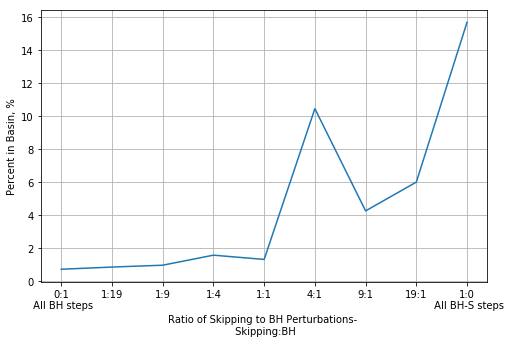

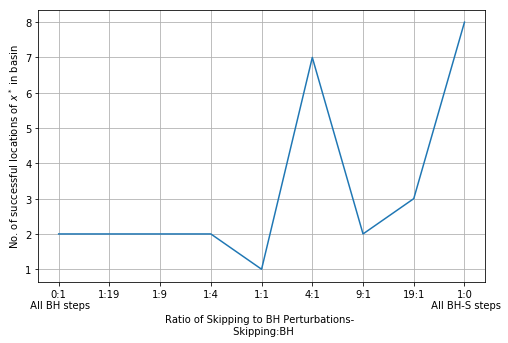

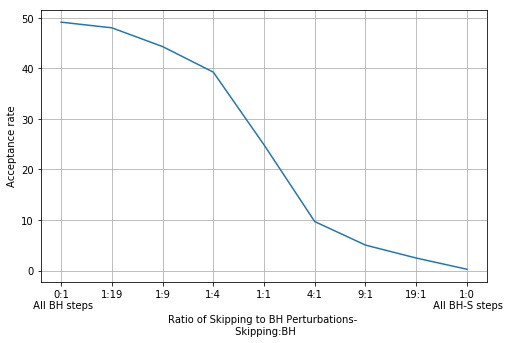

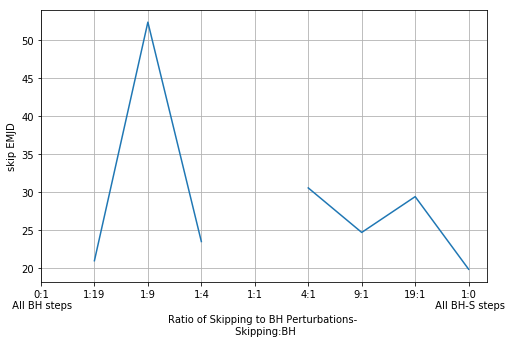

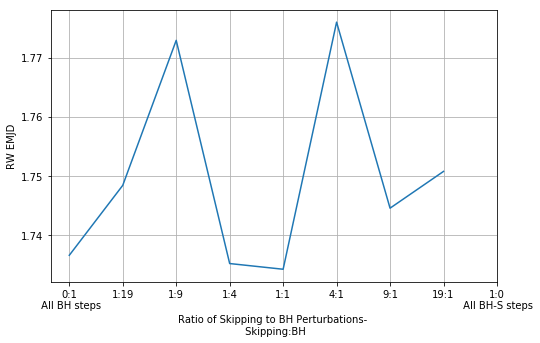

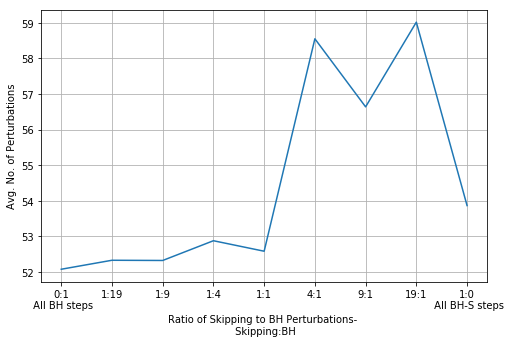

In [100]:
avg_perturbations = total_iterations_s/total_trials_s
l=[0,1/20,1/10,1/5,1,5,10,20,100]
xlab = ['0:1','1:19','1:9','1:4','1:1','4:1','9:1','19:1','1:0']
xlab = ['0:1\n All BH steps','1:19','1:9','1:4','1:1','4:1','9:1','19:1','1:0\n All BH-S steps']

x = range(0,9)

plt.figure(figsize=(8,5)) 
plt.plot(x,PIB_s[0])
plt.xticks(x,xlab)
plt.xlabel('Ratio of Skipping to BH Perturbations- \n Skipping:BH')
plt.ylabel('Percent in Basin, %')
plt.grid()
plt.show()

plt.figure(figsize=(8,5)) 
plt.plot(x,total_in_basin_s[0])
plt.xticks(x,xlab)
plt.xlabel('Ratio of Skipping to BH Perturbations- \n Skipping:BH')
plt.ylabel('No. of successful locations of $x^*$ in basin')
plt.grid()
plt.show()
           
plt.figure(figsize=(8,5)) 
plt.plot(x,accept_rate_s[0])
plt.xticks(x,xlab)
plt.xlabel('Ratio of Skipping to BH Perturbations- \n Skipping:BH')
plt.ylabel('Acceptance rate')
plt.grid()
plt.show()

plt.figure(figsize=(8,5)) 
plt.plot(x,exp_EMJD_skip_s[0])
plt.xticks(x,xlab)
plt.xlabel('Ratio of Skipping to BH Perturbations- \n Skipping:BH')
plt.ylabel('skip EMJD')
plt.grid()
plt.show()

plt.figure(figsize=(8,5)) 
plt.plot(x,exp_EMJD_rw_s[0])
plt.xticks(x,xlab)
plt.xlabel('Ratio of Skipping to BH Perturbations- \n Skipping:BH')
plt.ylabel('RW EMJD')
plt.grid()
plt.show()

plt.figure(figsize=(8,5)) 
plt.plot(x,avg_perturbations[0])
plt.xticks(x,xlab)
plt.xlabel('Ratio of Skipping to BH Perturbations- \n Skipping:BH')
plt.ylabel('Avg. No. of Perturbations')
plt.grid()
plt.show()

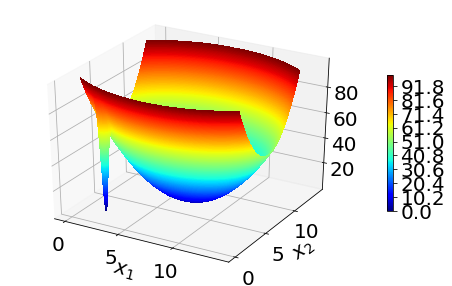

In [29]:
#%matplotlib notebook
from mpl_toolkits import mplot3d

def damavandi(x,y):
    return (1-(abs((sin(pi*(x-2))*sin(pi*(y-2)))/((pi**2)*(x-2)*(y-2))))**5)*(2 + (x-7)**2 + 2*(y-7)**2)

x = linspace(0,14,2000)
y = linspace(0,14,2000)

X,Y = meshgrid(x,y)
Z = damavandi(X,Y)

slevel =  100


tolerate = 0#.005

Z[Z>=slevel+tolerate]= nan
#Z[Z<slevel-tolerate]=nan
fig= plt.figure(figsize=(8,5))

ax = plt.axes(projection='3d')
#e = ax.plot_surface(X,Y,Z,cmap='jet',alpha=0.9)
e=plt.contourf(X,Y,Z,500,cmap='jet')

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize= 20) 

plt.xlabel('$x_1$',fontsize = 20)
plt.ylabel('$x_2$',fontsize =20)

#plt.title('    Egg-Holder Function: C = {x: f(x) < %.2f}'% (slevel+tolerate),fontsize=20)
plt.grid()
fig.colorbar(e,shrink=0.5,pad = 0.05)
plt.show()